In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Prepare usable data
prices = pd.read_csv('../dataset/AMZN/amzn-1d.csv',sep=',')
prices['Date'] = pd.to_datetime(prices['Date'])
prices.drop(columns=['Adj Close'])
msg = pd.read_csv('../dataset/AMZN/AMZN.csv',sep='\t',error_bad_lines=False,warn_bad_lines=True)
# UTC to EST: -5h
msg['CreatedAt'] = pd.to_datetime(msg['CreatedAt']) - datetime.timedelta(hours=5)
START_DATE = pd.to_datetime(prices.iloc[0]['Date']).date() - datetime.timedelta(5)
END_DATE = msg.iloc[0]['CreatedAt'].date()
msg = msg[msg['CreatedAt'] <= END_DATE]
msg = msg[msg['CreatedAt'] >= START_DATE]
prices = prices[prices['Date'] <= END_DATE]
prices = prices[prices['Date'] >= START_DATE]
msg['Date'] = msg['CreatedAt'].dt.date
msg = msg.drop(columns=['Id','CreatedAt','Body'],axis=1,inplace=False).fillna(0)
index = ['Date', 'Popularity', 'WeightedSentiment', 'SentimentVar']
sentiment_value = {'Bullish': 1, 'Neutral': 0, 'Bearish': -1, 0: 0}
def weighted_sentiment(row):
    ws = sentiment_value[row['Sentiment']] * row['Likes']
    return pd.Series([row['Date'], row['Likes']+1, ws, ws], index=index)
grouped = msg.apply(weighted_sentiment, axis=1).groupby('Date')

resetted = \
(grouped.aggregate({'Popularity': np.sum,
                    'WeightedSentiment': np.sum,
                    'SentimentVar': np.var})
        .rename(columns={'Popularity': 'Popularity',
                         'WeightedSentiment': 'WeightedSentiment',
                         'SentimentVar': 'SentimentVar'})
        .reset_index()
)
# msg takes effect on next day
resetted['Date'] = pd.to_datetime(resetted['Date']) + datetime.timedelta(1)
merged = pd.merge(prices,resetted,how='outer',on='Date',sort=True)
merged.head()

In [ ]:
merged['Popularity'].fillna(0,inplace=True)
merged['WeightedSentiment'].fillna(0,inplace=True)
merged['SentimentVar'].fillna(0,inplace=True)
def merge_na_rows(merged):
    Popularity = []
    WeightedSentiment = []
    SentimentVar = []
    acc_pop = 0
    acc_ws = 0
    acc_sv = 0
    count = 1
    for row in merged.itertuples():
        if pd.notna(row.Open):
            Popularity.append((row.Popularity + acc_pop)/count)
            WeightedSentiment.append((row.WeightedSentiment + acc_ws)/count)
            SentimentVar.append((row.SentimentVar + acc_sv)/count)
            acc_pop = 0
            acc_ws = 0
            acc_sv = 0
            count = 1
        else:
            acc_pop = acc_pop + row.Popularity
            acc_ws = acc_ws + row.WeightedSentiment
            acc_sv = acc_sv + row.SentimentVar
            count += 1
    merged = merged.dropna(axis=0,thresh=5).fillna(0)
    merged['Popularity'] = Popularity
    merged['WeightedSentiment'] = WeightedSentiment
    merged['SentimentVar'] = SentimentVar
    return merged
cleaned = merge_na_rows(merged)
# make ws pencentage based
cleaned['WeightedSentiment'] = cleaned['WeightedSentiment'] / cleaned['Popularity']
cleaned.index = cleaned['Date']
cleaned.drop(columns=['Date','Adj Close'],inplace=True)
cleaned.to_csv('AMZN-extr.csv')
cleaned.head(10)

In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def convert_csv(symbol):
    # Prepare usable data
    prices = pd.read_csv('../dataset/{}/{}-1d.csv'.format(symbol,symbol.lower()),sep=',')
    prices['Date'] = pd.to_datetime(prices['Date'])
    prices.drop(columns=['Adj Close'])
    msg = pd.read_csv('../dataset/{}/{}.csv'.format(symbol,symbol),sep='\t',error_bad_lines=False,warn_bad_lines=True)
    # UTC to EST: -5h
    msg['CreatedAt'] = pd.to_datetime(msg['CreatedAt']) - datetime.timedelta(hours=5)
    START_DATE = pd.to_datetime(prices.iloc[0]['Date']).date() - datetime.timedelta(5)
    END_DATE = msg.iloc[0]['CreatedAt'].date()
    msg = msg[msg['CreatedAt'] <= END_DATE]
    msg = msg[msg['CreatedAt'] >= START_DATE]
    prices = prices[prices['Date'] <= END_DATE]
    prices = prices[prices['Date'] >= START_DATE]
    msg['Date'] = msg['CreatedAt'].dt.date
    msg = msg.drop(columns=['Id','CreatedAt','Body'],axis=1,inplace=False).fillna(0)
    index = ['Date', 'Popularity', 'WeightedSentiment', 'SentimentVar']
    sentiment_value = {'Bullish': 1, 'Neutral': 0, 'Bearish': -1, 0: 0}
    def weighted_sentiment(row):
        ws = sentiment_value[row['Sentiment']] * row['Likes']
        return pd.Series([row['Date'], row['Likes']+1, ws, ws], index=index)
    grouped = msg.apply(weighted_sentiment, axis=1).groupby('Date')
    resetted = \
    (grouped.aggregate({'Popularity': np.sum,
                        'WeightedSentiment': np.sum,
                        'SentimentVar': np.var})
            .rename(columns={'Popularity': 'Popularity',
                             'WeightedSentiment': 'WeightedSentiment',
                             'SentimentVar': 'SentimentVar'})
            .reset_index()
    )
    # msg takes effect on next day
    resetted['Date'] = pd.to_datetime(resetted['Date']) + datetime.timedelta(1)
    merged = pd.merge(prices,resetted,how='outer',on='Date',sort=True)
    merged['Popularity'].fillna(0,inplace=True)
    merged['WeightedSentiment'].fillna(0,inplace=True)
    merged['SentimentVar'].fillna(0,inplace=True)
    def merge_na_rows(merged):
        Popularity = []
        WeightedSentiment = []
        SentimentVar = []
        acc_pop = 0
        acc_ws = 0
        acc_sv = 0
        count = 1
        for row in merged.itertuples():
            if pd.notna(row.Open):
                Popularity.append((row.Popularity + acc_pop)/count)
                WeightedSentiment.append((row.WeightedSentiment + acc_ws)/count)
                SentimentVar.append((row.SentimentVar + acc_sv)/count)
                acc_pop = 0
                acc_ws = 0
                acc_sv = 0
                count = 1
            else:
                acc_pop = acc_pop + row.Popularity
                acc_ws = acc_ws + row.WeightedSentiment
                acc_sv = acc_sv + row.SentimentVar
                count += 1
        merged = merged.dropna(axis=0,thresh=5).fillna(0)
        merged['Popularity'] = Popularity
        merged['WeightedSentiment'] = WeightedSentiment
        merged['SentimentVar'] = SentimentVar
        return merged
    cleaned = merge_na_rows(merged)
    # make ws pencentage based
    cleaned['WeightedSentiment'] = cleaned['WeightedSentiment'] / cleaned['Popularity']
    cleaned.index = cleaned['Date']
    cleaned.drop(columns=['Date','Adj Close'],inplace=True)
    cleaned.to_csv('{}-extr.csv'.format(symbol))
    
convert_csv('AAPL')
convert_csv('GOOGL')

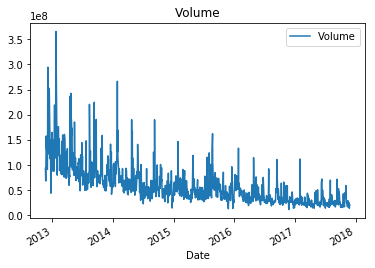

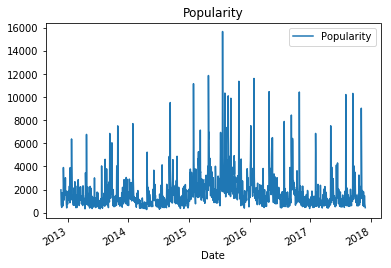

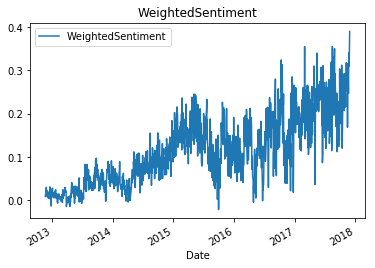

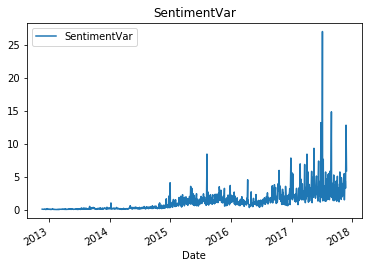

,Open,High,Low,Close,Volume,Popularity,WeightedSentiment,SentimentVar
Date,,,,,,,,
2012-11-21,80.607140,81.052856,79.514282,80.242859,93250500.0,1972.600000,0.009125,0.068437
2012-11-23,81.024284,81.714287,80.371429,81.642860,68206600.0,679.500000,0.014717,0.060949
2012-11-26,82.271431,84.285713,81.958572,84.218575,157644900.0,454.666667,0.017595,0.057945
2012-11-27,84.221428,84.345711,82.871429,83.540001,133332500.0,1716.000000,0.030303,0.046802
2012-11-28,82.467140,83.685715,81.751427,83.277145,130216100.0,1405.000000,0.018505,0.030448


In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
cleaned = pd.read_csv('AAPL-extr.csv',index_col='Date',parse_dates=True)
columns = ['Volume', 'Popularity','WeightedSentiment', 'SentimentVar']
# plot each column
for col in columns:
    cleaned[col].plot(legend=True,title=col)
    plt.show()
cleaned.head()

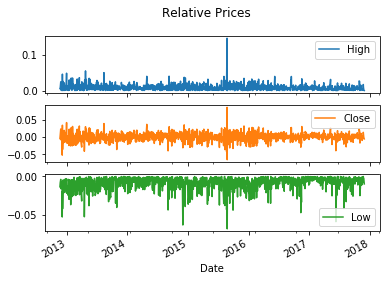

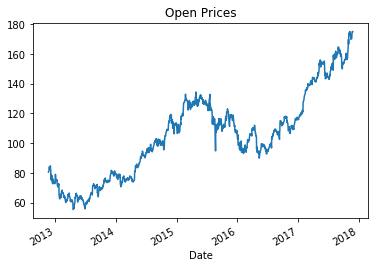

In [2]:
# LSTM Data Preparation
for col in ['High', 'Close', 'Low']:
    cleaned[col] = (cleaned[col] - cleaned['Open']) / cleaned['Open']
pd.DataFrame(cleaned,columns=['High', 'Close', 'Low']).plot(title='Relative Prices',subplots=True)
plt.show()
cleaned['Open'].plot(title='Open Prices')
plt.show()

In [3]:
cleaned.head()

,Open,High,Low,Close,Volume,Popularity,WeightedSentiment,SentimentVar
Date,,,,,,,,
2012-11-21,80.607140,0.005529,-0.013558,-0.004519,93250500.0,1972.600000,0.009125,0.068437
2012-11-23,81.024284,0.008516,-0.008058,0.007634,68206600.0,679.500000,0.014717,0.060949
2012-11-26,82.271431,0.024483,-0.003803,0.023667,157644900.0,454.666667,0.017595,0.057945
2012-11-27,84.221428,0.001476,-0.016029,-0.008091,133332500.0,1716.000000,0.030303,0.046802
2012-11-28,82.467140,0.014776,-0.008679,0.009822,130216100.0,1405.000000,0.018505,0.030448


In [4]:
# Transform the time series into a supervised learning problem by shifting
data = cleaned.drop(columns=[])
for name in ['High', 'Low', 'Volume', 'Popularity', 'WeightedSentiment', 'SentimentVar']:
    data[name] = data[name].shift(1)
data['LastClose'] = data['Close'].shift(1)
# Transform the Open Price so that it is stationary.
opens = cleaned['Open']
data['Open'] = (data['Open'] - data['Close'].shift(1)) / data['Open']
data.dropna(inplace=True)
# Transform the observations to have a specific scale.
# prices are fit by only 'Close', which is the target
from sklearn.preprocessing import MinMaxScaler
prices_scaler = MinMaxScaler(feature_range=(-1,1))
prices_scaler.fit(data[['Close']])
data[['Open','Close','LastClose']] = prices_scaler.transform(data[['Open','Close','LastClose']])
data[['High','Low']] = prices_scaler.transform(data[['High','Low']])

scaler = MinMaxScaler(feature_range=(0,1))
scaler_groups = ['Open','Volume','Popularity','WeightedSentiment','SentimentVar']
data[scaler_groups] = scaler.fit_transform(data[scaler_groups])

data.head()

,Open,High,Low,Close,Volume,Popularity,WeightedSentiment,SentimentVar,LastClose
Date,,,,,,,,,
2012-11-23,0.558530,-0.062439,-0.311472,-0.034976,0.231173,0.110602,0.079838,0.002197,-0.193545
2012-11-26,0.459558,-0.023474,-0.239709,0.174205,0.160375,0.026638,0.094713,0.001919,-0.034976
2012-11-27,0.334175,0.184852,-0.184197,-0.240145,0.413214,0.012039,0.102370,0.001808,0.174205
2012-11-28,0.586732,-0.115330,-0.343715,-0.006433,0.344483,0.093940,0.136174,0.001395,-0.240145
2012-11-29,0.443773,0.058206,-0.247815,-0.153594,0.335673,0.073746,0.104791,0.000788,-0.006433


In [5]:
from sklearn.model_selection import train_test_split
closes = data['Close']
data.drop(columns=['Close'],inplace=True)
# data.drop(columns=['Close','Popularity','WeightedSentiment','SentimentVar'],inplace=True)
x_train, x_test, y_train, y_test = train_test_split(data,closes,test_size=0.20,shuffle=False)

baseline RMSE: 0.011400
transformed baseline MSE: 0.022122
baseline metrics: (0.53956834532374098, 0.53956834532374098, 0.53956834532374098, None)

naive RMSE: 0.008297
transformed naive MSE: 0.011719
naive metrics: (0.54940711462450598, 1.0, 0.70918367346938782, None)



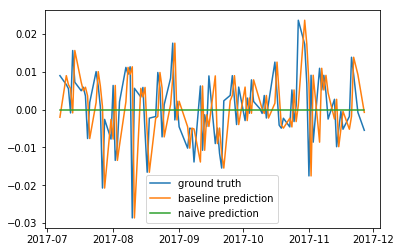

'\nbaseline RMSE: 0.011400\ntransformed baseline MSE: 0.022122\nbaseline metrics: (0.53956834532374098, 0.53956834532374098, 0.53956834532374098, None)\n\nnaive RMSE: 0.008297\ntransformed naive MSE: 0.011719\nnaive metrics: (0.54940711462450598, 1.0, 0.70918367346938782, None)\n'

In [6]:
def reverse_y(y):
    df = pd.DataFrame(y)
    df['Reversed'] = prices_scaler.inverse_transform(df)
    return df['Reversed'] 
truth = reverse_y(y_test)

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import precision_recall_fscore_support
def eval_report(truth,pred):
    y_target = (truth >= 0).astype(np.int)
    y_pred = (pred >= 0).astype(np.int)
    return precision_recall_fscore_support(y_target,y_pred,average='binary')
def evaluate_pred(predictions, label=''):
    rmse = sqrt(mean_squared_error(truth,predictions))
    print(label + ' RMSE: %.6f'%rmse)
    transformed_mse = mean_squared_error(y_test,prices_scaler.transform(predictions.values.reshape(-1,1)))
    print('transformed ' + label + ' MSE: %.6f'%transformed_mse)
    print(label + ' metrics: {}\n'.format(eval_report(truth,predictions)))

# Baseline Prediction
baseline_predictions = reverse_y(x_test['LastClose'])
evaluate_pred(baseline_predictions, 'baseline')

# Naive Prediction
naive_predictions = x_test['Open'] - x_test['Open']
evaluate_pred(naive_predictions, 'naive')

# ground truth vs prediction
plt.plot(truth[-100:],label='ground truth')
plt.plot(baseline_predictions[-100:],label='baseline prediction')
plt.plot(naive_predictions[-100:],label='naive prediction')
plt.legend()
plt.show()

'''
baseline RMSE: 0.011400
transformed baseline MSE: 0.022122
baseline metrics: (0.53956834532374098, 0.53956834532374098, 0.53956834532374098, None)

naive RMSE: 0.008297
transformed naive MSE: 0.011719
naive metrics: (0.54940711462450598, 1.0, 0.70918367346938782, None)
'''

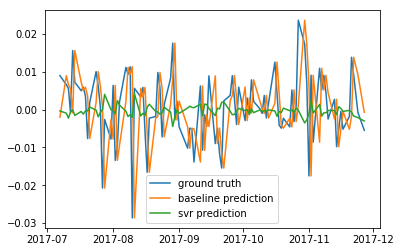

In [52]:
plt.plot(truth[-100:],label='ground truth')
plt.plot(baseline_predictions[-100:],label='baseline prediction')
plt.plot(reverse_y(svr_pred)[-100:],label='svr prediction')

plt.legend()
plt.show()

In [51]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train,y_train)
svr_pred = pd.Series(svr.predict(x_test),index=x_test.index)
evaluate_pred(reverse_y(svr_pred), 'svr')

svr RMSE: 0.008494
transformed svr MSE: 0.012282
svr metrics: (0.60317460317460314, 0.2733812949640288, 0.37623762376237629, None)



In [22]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train,y_train)
lr_pred = pd.Series(lr.predict(x_test),index=x_test.index)
evaluate_pred(reverse_y(lr_pred), 'LinearRegression')

LinearRegression RMSE: 0.009144
transformed LinearRegression MSE: 0.014232
LinearRegression metrics: (0.61224489795918369, 0.21582733812949639, 0.31914893617021278, None)



In [64]:
from sklearn.metrics import r2_score
r2_score(truth,reverse_y(lr_pred))

-0.23575448468930404

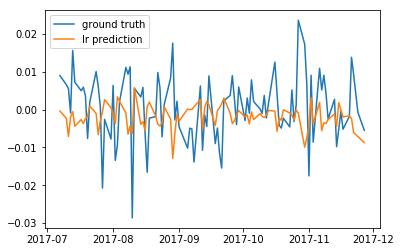

In [68]:
# ground truth vs prediction
plt.plot(truth[-100:],label='ground truth')
plt.plot(reverse_y(lr_pred)[-100:],label='lr prediction')
plt.legend()
plt.show()

Train on 1009 samples, validate on 253 samples
Epoch 1/40
1009/1009 [==============================] - 7s 7ms/step - loss: 0.0303 - val_loss: 0.0132
Epoch 2/40
1009/1009 [==============================] - 5s 5ms/step - loss: 0.0290 - val_loss: 0.0133
Epoch 3/40
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0288 - val_loss: 0.0132
Epoch 4/40
1009/1009 [==============================] - 7s 7ms/step - loss: 0.0287 - val_loss: 0.0131
Epoch 5/40
1009/1009 [==============================] - 7s 7ms/step - loss: 0.0286 - val_loss: 0.0130
Epoch 6/40
1009/1009 [==============================] - 7s 7ms/step - loss: 0.0285 - val_loss: 0.0129
Epoch 7/40
1009/1009 [==============================] - 7s 7ms/step - loss: 0.0285 - val_loss: 0.0129
Epoch 8/40
1009/1009 [==============================] - 6s 6ms/step - loss: 0.0284 - val_loss: 0.0128
Epoch 9/40
1009/1009 [==============================] - 7s 7ms/step - loss: 0.0283 - val_loss: 0.0128
Epoch 10/40
1009/1009 [============

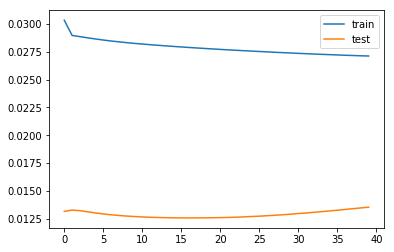

'\n20 60\ntransformed MSE: 0.012302\nreversed RMSE: 0.008501\nbaseline metrics: (0.60833333333333328, 0.52517985611510787, 0.56370656370656358, None)\n\n20 40\ntransformed MSE: 0.012703\nreversed RMSE: 0.008639\nbaseline metrics: (0.57615894039735094, 0.62589928057553956, 0.59999999999999998, None)\n\n40 20\ntransformed MSE: 0.012550\nreversed RMSE: 0.008586\nbaseline metrics: (0.57516339869281041, 0.63309352517985606, 0.60273972602739723, None)\n\n30, 8\ntransformed MSE: 0.012784\nreversed RMSE: 0.008666\nbaseline metrics: (0.62264150943396224, 0.47482014388489208, 0.53877551020408154, None)\n\n50, 6\ntransformed MSE: 0.012322\nreversed RMSE: 0.008508\nbaseline metrics: (0.64634146341463417, 0.38129496402877699, 0.47963800904977383, None)\n\n30, 5\ntransformed MSE: 0.012836\nreversed RMSE: 0.008684\nbaseline metrics: (0.60869565217391308, 0.40287769784172661, 0.48484848484848486, None)\n\n100, 5\ntransformed MSE: 0.014874\nreversed RMSE: 0.009348\nbaseline metrics: (0.5895522388059701

In [61]:
# LSTM Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
def fit_lstm(x_train, y_train, x_test, y_test, batch_size=1, nb_epoch=100, neurons=5):
    x_train = x_train.values.reshape(x_train.shape[0], 1, x_train.shape[1])
    x_test = x_test.values.reshape(x_test.shape[0], 1, x_test.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, x_train.shape[1], x_train.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size,
                        validation_data=(x_test,y_test),
                        verbose=1, shuffle=False)
    return model, history

lstm_model, history = fit_lstm(x_train, y_train, x_test, y_test, 1, 40, 4)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

'''
20 60
transformed MSE: 0.012302
reversed RMSE: 0.008501
baseline metrics: (0.60833333333333328, 0.52517985611510787, 0.56370656370656358, None)

20 40
transformed MSE: 0.012703
reversed RMSE: 0.008639
baseline metrics: (0.57615894039735094, 0.62589928057553956, 0.59999999999999998, None)

40 20
transformed MSE: 0.012550
reversed RMSE: 0.008586
baseline metrics: (0.57516339869281041, 0.63309352517985606, 0.60273972602739723, None)

30, 8
transformed MSE: 0.012784
reversed RMSE: 0.008666
baseline metrics: (0.62264150943396224, 0.47482014388489208, 0.53877551020408154, None)

50, 6
transformed MSE: 0.012322
reversed RMSE: 0.008508
baseline metrics: (0.64634146341463417, 0.38129496402877699, 0.47963800904977383, None)

30, 5
transformed MSE: 0.012836
reversed RMSE: 0.008684
baseline metrics: (0.60869565217391308, 0.40287769784172661, 0.48484848484848486, None)

100, 5
transformed MSE: 0.014874
reversed RMSE: 0.009348
baseline metrics: (0.58955223880597019, 0.56834532374100721, 0.57875457875457881, None)

30, 4
transformed MSE: 0.012236
reversed RMSE: 0.008478
baseline metrics: (0.66153846153846152, 0.30935251798561153, 0.42156862745098045, None)
transformed MSE: 0.013590
reversed RMSE: 0.008935
baseline metrics: (0.63855421686746983, 0.38129496402877699, 0.47747747747747743, None)

30, 3
transformed MSE: 0.012665
reversed RMSE: 0.008626
baseline metrics: (0.64383561643835618, 0.33812949640287771, 0.44339622641509435, None)

no sentiment
10, 5
transformed MSE: 0.012689
reversed RMSE: 0.008634
baseline metrics: (0.54128440366972475, 0.42446043165467628, 0.47580645161290325, None)
'''

In [62]:
# LSTM Prediction
y_pred = lstm_model.predict(
    x_test.values.reshape(x_test.shape[0],1,x_test.shape[1]),
    batch_size=1,verbose=0)
transformed_mse = mean_squared_error(y_test,y_pred)
print('transformed MSE: %.6f'%transformed_mse)
reversed_pred = reverse_y(y_pred)
reversed_rmse = sqrt(mean_squared_error(truth,reversed_pred))
print('reversed RMSE: %.6f'%reversed_rmse)
print('baseline metrics: {}'.format(eval_report(truth,reversed_pred)))

transformed MSE: 0.013590
reversed RMSE: 0.008935
baseline metrics: (0.63855421686746983, 0.38129496402877699, 0.47747747747747743, None)


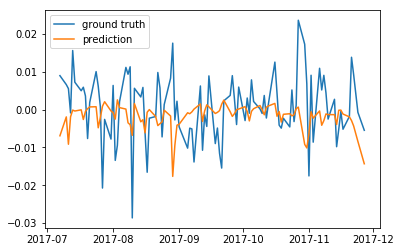

In [63]:
# ground truth vs prediction
reversed_pred.index = x_test.index
plt.plot(truth[-100:],label='ground truth')
plt.plot(reversed_pred[-100:],label='prediction')
plt.legend()
plt.show()